# Finding blobs in 64x64 images using conv2d

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from scipy.optimize import curve_fit
from PIL import Image
import random

# Get data

Data reading function

In [2]:
def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((j, k))

            images.append(slice_)

        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

In [3]:
def leaky_relu(inp, alpha=0.2):
    return tf.maximum(inp * alpha, inp)
    

Read in blobs tiff

In [4]:
all_dataA=read_tiff('OutlinesA.tif',10000)
#all_dataB=read_tiff('CountBlobsB.tif',10000)
#all_dataC=read_tiff('CountBlobsC.tif',10000)

In [5]:
all_truthsA=read_tiff('OutlinesTruthA.tif',10000)
#dfB=pd.read_csv('CountBlobsTruthB.csv')
#dfC=pd.read_csv('CountBlobsTruthC.csv')

Read in truth table

# Design network

Define a function to create a convolutional layer, including conv, relu, maxpool, that can be called multiple times

In [53]:
#Input and output
x=tf.placeholder(dtype=tf.float32, shape=[None, 64,64])
y=tf.placeholder(dtype=tf.float32, shape=[None, 64,64])

xr=tf.reshape(x, [-1, 64,64,1])
yr=tf.reshape(y, [-1, 64,64,1])

base_scaler=64

#Going down
A1=leaky_relu(tf.layers.conv2d(xr, base_scaler, [3,3], padding='SAME'))
A2=leaky_relu(tf.layers.conv2d(A1, base_scaler, [3,3], padding='SAME'))

B0=tf.nn.max_pool(A2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
B1=leaky_relu(tf.contrib.layers.conv2d(B0, 2*base_scaler, [3,3], padding='SAME'))
B2=leaky_relu(tf.contrib.layers.conv2d(B1, 2*base_scaler, [3,3], padding='SAME'))

C0=tf.nn.max_pool(B2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
C1=leaky_relu(tf.contrib.layers.conv2d(C0, 4*base_scaler, [3,3], padding='SAME'))
C2=leaky_relu(tf.contrib.layers.conv2d(C1, 4*base_scaler, [3,3], padding='SAME'))

D0=tf.nn.max_pool(C2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
D1=leaky_relu(tf.contrib.layers.conv2d(D0, 8*base_scaler, [3,3], padding='SAME'))
D2=leaky_relu(tf.contrib.layers.conv2d(D1, 8*base_scaler, [3,3], padding='SAME'))

E0=tf.nn.max_pool(D2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
E1=leaky_relu(tf.contrib.layers.conv2d(E0, 16*base_scaler, [3,3], padding='SAME'))
E2=leaky_relu(tf.contrib.layers.conv2d(E1, 16*base_scaler, [3,3], padding='SAME'))

#Put in a dense layer, probably not a good idea
using_fully_connected=0
if using_fully_connected==1:
    flattened=tf.reshape(E2, [-1,16*base_scaler*4*4 ])
    dense1=tf.contrib.layers.fully_connected(flattened,128)
    dense2=tf.contrib.layers.fully_connected(dense1,16*base_scaler*4*4)
    unflattened=tf.reshape(dense2, [-1, 4,4,16*base_scaler])
    DD0=tf.contrib.layers.conv2d_transpose(unflattened, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
else:
    DD0=tf.contrib.layers.conv2d_transpose(E2, 8*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')

#Coming up
DD1=tf.concat(axis=3, values=[DD0,D2])
DD2=leaky_relu(tf.contrib.layers.conv2d(DD1, 8*base_scaler, [3,3], padding='SAME'))
DD3=leaky_relu(tf.contrib.layers.conv2d(DD2, 8*base_scaler, [3,3], padding='SAME'))

CC0=tf.contrib.layers.conv2d_transpose(DD3, 4*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
CC1=tf.concat(axis=3, values=[CC0,C2])
CC2=leaky_relu(tf.contrib.layers.conv2d(CC1, 4*base_scaler, [3,3], padding='SAME'))
CC3=leaky_relu(tf.contrib.layers.conv2d(CC2, 4*base_scaler, [3,3], padding='SAME'))

BB0=tf.contrib.layers.conv2d_transpose(CC3, 2*base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
BB1=tf.concat(axis=3, values=[BB0,B2])
BB2=leaky_relu(tf.contrib.layers.conv2d(BB1, 2*base_scaler, [3,3], padding='SAME'))
BB3=leaky_relu(tf.contrib.layers.conv2d(BB2, 2*base_scaler, [3,3], padding='SAME'))

AA0=tf.contrib.layers.conv2d_transpose(BB3, base_scaler, kernel_size=[3,3], stride=[2, 2], padding='SAME')
AA1=tf.concat(axis=3, values=[AA0,A2])
AA2=leaky_relu(tf.contrib.layers.conv2d(AA1, base_scaler, [3,3], padding='SAME'))
AA3=leaky_relu(tf.contrib.layers.conv2d(AA2, base_scaler, [3,3], padding='SAME'))

logits=leaky_relu(tf.contrib.layers.conv2d(AA3, 1, [1,1], padding='SAME'))
probs=tf.tanh(logits)

diff=tf.subtract(probs, yr)
LSQ=tf.multiply(diff,diff)
loss=tf.reduce_mean(LSQ)

train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)



# Training on easy set

In [54]:
all_data=(all_dataA)/255.0

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [55]:
all_truths=all_truthsA/255.0

train_truth=all_truths[0:6000, :,:]
validation_truth=all_truths[6001:8000, :,:]
test_truth=all_truths[8001:10000, :,:]

In [65]:
tf.set_random_seed(123456)
sess=tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(100):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:,:]
    _,results, LN,losses=sess.run([train_op, logits, probs, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%10==0):
        print("Error rate: ", logits.shape)
        print("Real loss: ",losses)

Error rate:  (?, 64, 64, 1)
Real loss:  0.08853368
Error rate:  (?, 64, 64, 1)
Real loss:  0.037616592
Error rate:  (?, 64, 64, 1)
Real loss:  0.0087180985
Error rate:  (?, 64, 64, 1)
Real loss:  0.0025856667
Error rate:  (?, 64, 64, 1)
Real loss:  0.0018864146
Error rate:  (?, 64, 64, 1)
Real loss:  0.001529689
Error rate:  (?, 64, 64, 1)
Real loss:  0.0020311142
Error rate:  (?, 64, 64, 1)
Real loss:  0.0015189609
Error rate:  (?, 64, 64, 1)
Real loss:  0.0014375988
Error rate:  (?, 64, 64, 1)
Real loss:  0.0013167693


[0.0, 6.385223]
58


(100, 64, 64, 1)

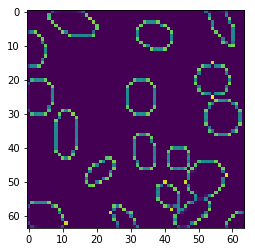

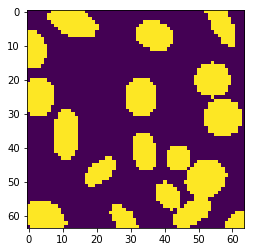

In [66]:

ix=random.randint(1,64)
plt.figure()
plt.imshow(results[0,:,:,0])
plt.figure()
plt.imshow(cur_train[0,:,:])

print([np.min(results[1,:,:,0]), np.max(results[1,:,:,0])])
print(ix)
results.shape

0.5

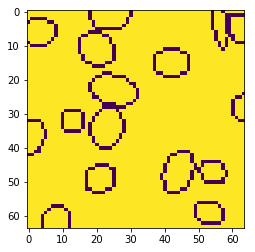

In [42]:
plt.imshow(results[1,:,:,0])
np.max(results[1,:,:,0])

In [69]:
sub_range=range(0,100)
sub_validation_data=validation_data[sub_range, :,:]
sub_validation_truth=validation_truth[sub_range, :,:]
results, LN,losses=sess.run([probs, LSQ, loss], feed_dict={x:sub_validation_data, y:sub_validation_truth})

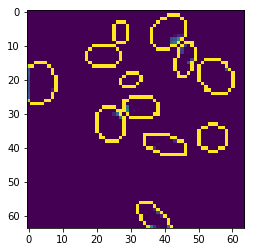

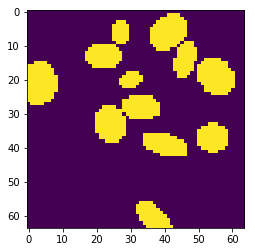

In [84]:

ix=random.randint(1,64)
plt.figure()
plt.imshow(results[ix,:,:,0])
plt.figure()
plt.imshow(sub_validation_data[ix,:,:])



# Training on middle set

In [199]:
all_data=all_dataB

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [200]:
df=dfB

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [201]:

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  18.7572
Error rate:  (100, 1)
Real loss:  0.373632
Error rate:  (100, 1)
Real loss:  0.36003
Error rate:  (100, 1)
Real loss:  0.15307
Error rate:  (100, 1)
Real loss:  0.229855
Error rate:  (100, 1)
Real loss:  0.108818
Error rate:  (100, 1)
Real loss:  0.0673801


In [202]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

4
4.44682
23.0768066406


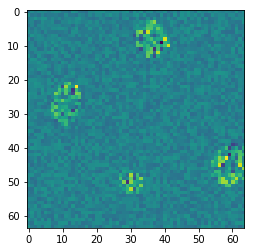

In [207]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Training on final set

In [208]:
all_data=all_dataC

train_data=all_data[0:6000, :,:]
validation_data=all_data[6001:8000, :,:]
test_data=all_data[8001:10000, :,:]

In [209]:
df=dfC

all_truth=df['Blobs'].as_matrix()
all_truth=all_truth.reshape(all_truth.shape[0], 1)
train_truth=all_truth[0:6000, :]
validation_truth=all_truth[6001:8000, :]
test_truth=all_truth[8001:10000, :]

In [214]:

for i in range(2000):
    idx=np.random.choice(6000, replace=False, size=[100])
    cur_train=train_data[idx,:,:]
    cur_truth=train_truth[idx,:]
    _,results, LN,losses=sess.run([train_op, logits, LS, loss], feed_dict={x:cur_train, y:cur_truth})
    if (i%300==0):
        print("Error rate: ", LN.shape)
        print("Real loss: ",losses)

Error rate:  (100, 1)
Real loss:  0.0740829
Error rate:  (100, 1)
Real loss:  0.0431278
Error rate:  (100, 1)
Real loss:  0.0310682
Error rate:  (100, 1)
Real loss:  0.0351322
Error rate:  (100, 1)
Real loss:  0.0267674
Error rate:  (100, 1)
Real loss:  0.0110069
Error rate:  (100, 1)
Real loss:  0.00699636


In [215]:
results, LN,losses=sess.run([logits, LS, loss], feed_dict={x:validation_data, y:validation_truth})

8
7.58809
21.6808105469


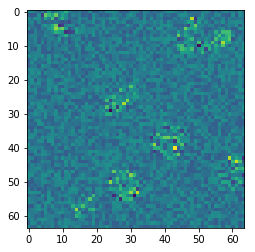

In [224]:
rid=random.randint(0,1999)
plt.imshow(validation_data[rid,:,:])
print(validation_truth[rid,0])
print(results[rid,0])
print(np.mean(validation_data[rid,:,:])/5)

# Compare to simple mean

In [225]:
validation_truth.shape

(1999, 1)

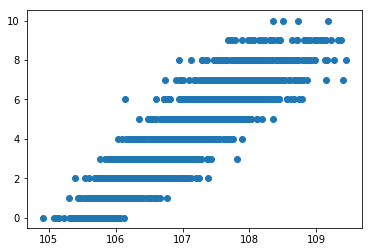

In [226]:
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

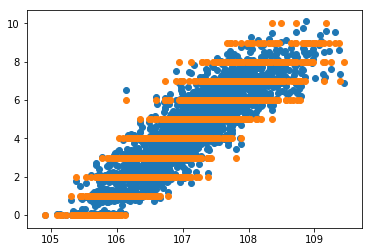

In [227]:
plt.scatter(np.mean(validation_data, axis=(1,2)), results[:,0])
plt.scatter(np.mean(validation_data, axis=(1,2)), validation_truth[:,0])

(array([[  98.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   2.,  209.,    3.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    9.,  215.,   10.,    0.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,   12.,  195.,   20.,    0.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,   27.,  192.,   34.,    0.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,   34.,  214.,   37.,    0.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    3.,   46.,  206.,   40.,    0.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    3.,   56.,  146.,   21.,
            0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    7.,   38.,   69.,
            9.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.,    1.,   15.,
           28.]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.]),
 array([  0.,   1.,   2.,   3., 

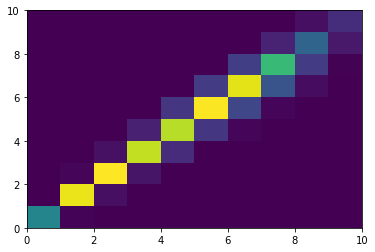

In [232]:
plt.hist2d(validation_truth[:,0], np.round(results[:,0]))